In [2]:
import pandas as pd
import os

data_dir = "yellow_taxi_datasets"
csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]
df_list = [pd.read_csv(os.path.join(data_dir, file)) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

In [3]:
print(f"Combined shape: {df.shape}")
df.head()

Combined shape: (47248845, 20)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,RatecodeID
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1.0,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05,NaN
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1.0,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80,NaN
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1.0,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,NaN
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1.0,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,NaN
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1.0,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30,NaN


# Feature Engineering

In [4]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

df = df[(df['trip_duration'] > 0) & (df['trip_duration'] < 180)]
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] < 100)]

df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['weekday'] = df['tpep_pickup_datetime'].dt.dayofweek
df['month'] = df['tpep_pickup_datetime'].dt.month
df['day_name'] = df['tpep_pickup_datetime'].dt.day_name()

df.rename(columns={
    'pickup_latitude': 'pickup_lat',
    'pickup_longitude': 'pickup_lon',
    'dropoff_latitude': 'dropoff_lat',
    'dropoff_longitude': 'dropoff_lon'
}, inplace=True)

df.drop(columns=['RatecodeID'], inplace=True, errors='ignore')

# Data Visualization

## Trip Duration vs. Trip Distance

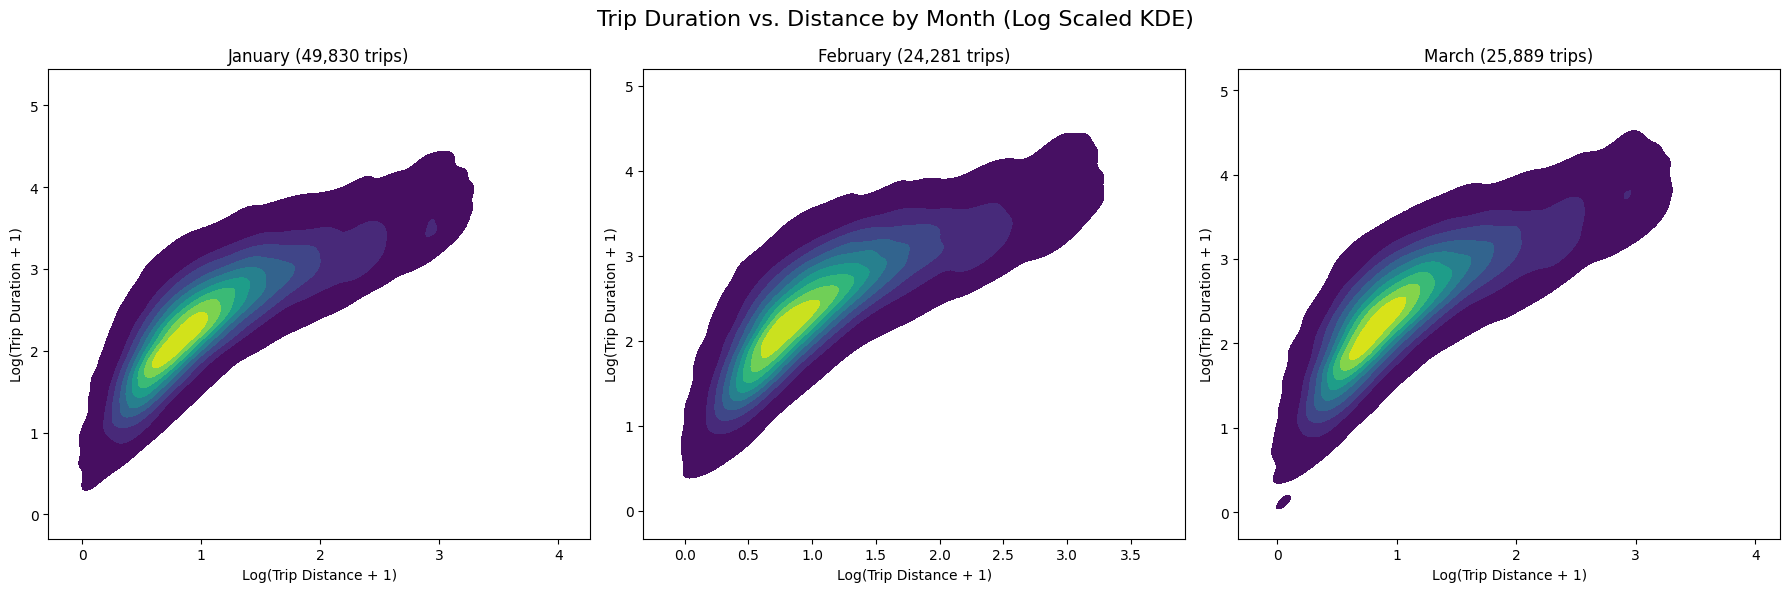

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sample_df = df.sample(100_000).copy()
sample_df['log_duration'] = np.log1p(sample_df['trip_duration'])
sample_df['log_distance'] = np.log1p(sample_df['trip_distance'])


titles = {1: "January", 2: "February", 3: "March"}
available_months = sorted(sample_df['month'].unique())

fig, axes = plt.subplots(1, len(available_months), figsize=(6 * len(available_months), 6))

if len(available_months) == 1:
    axes = [axes]

for ax, month in zip(axes, available_months):
    month_df = sample_df[sample_df['month'] == month]
    sns.kdeplot(
        data=month_df,
        x="log_distance",
        y="log_duration",
        cmap="viridis",
        fill=True,
        thresh=0.01,
        ax=ax
    )
    ax.set_title(f"{titles.get(month, f'Month {month}')} ({len(month_df):,} trips)")
    ax.set_xlabel("Log(Trip Distance + 1)")
    ax.set_ylabel("Log(Trip Duration + 1)")

plt.suptitle("Trip Duration vs. Distance by Month (Log Scaled KDE)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## Number of Trips by Hour of the Day

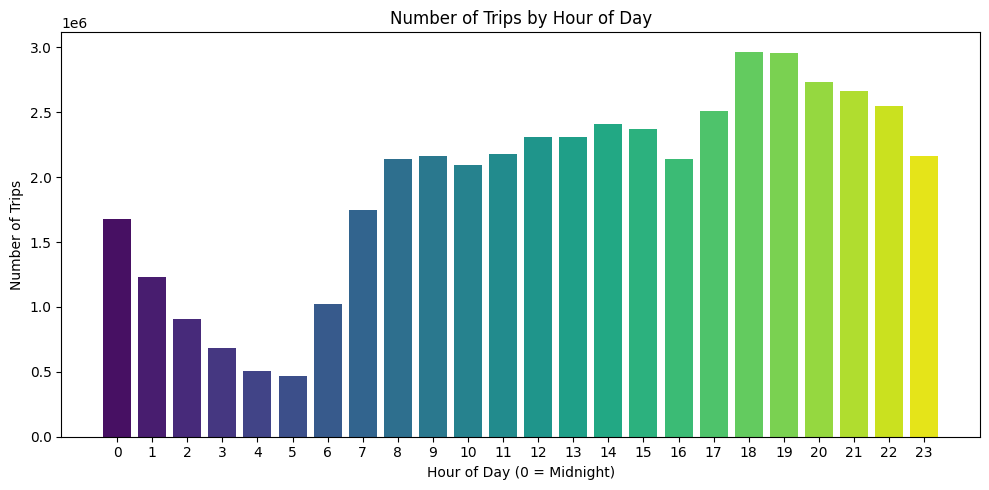

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

hour_counts = df['hour'].value_counts().sort_index()
colors = sns.color_palette("viridis", len(hour_counts))

plt.figure(figsize=(10, 5))
plt.bar(hour_counts.index, hour_counts.values, color=colors)
plt.title("Number of Trips by Hour of Day")
plt.xlabel("Hour of Day (0 = Midnight)")
plt.ylabel("Number of Trips")
plt.xticks(range(24))
plt.tight_layout()
plt.show()

## Number of Taxi Trips by Day of the Week

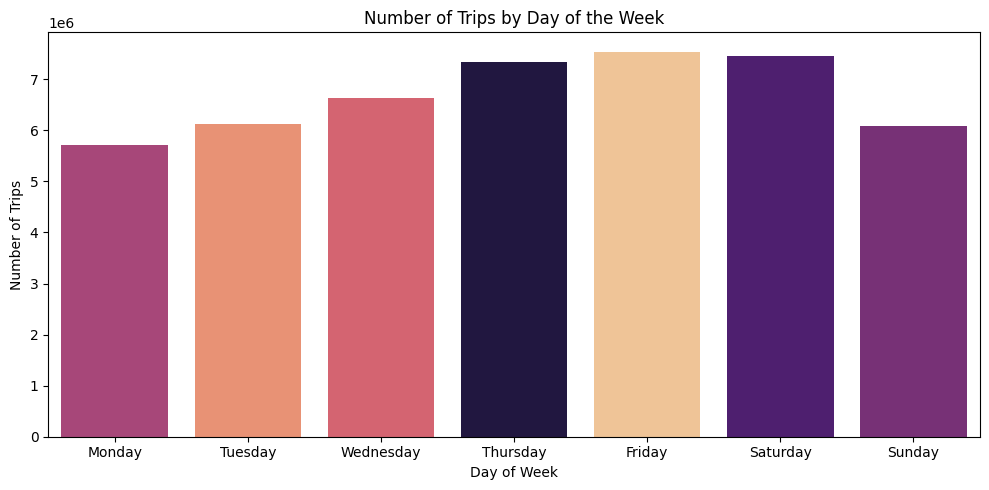

In [6]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='day_name', order=day_order, hue='day_name', palette='magma', legend=False)
plt.title("Number of Trips by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()

## Hour x Weekday Heatmap

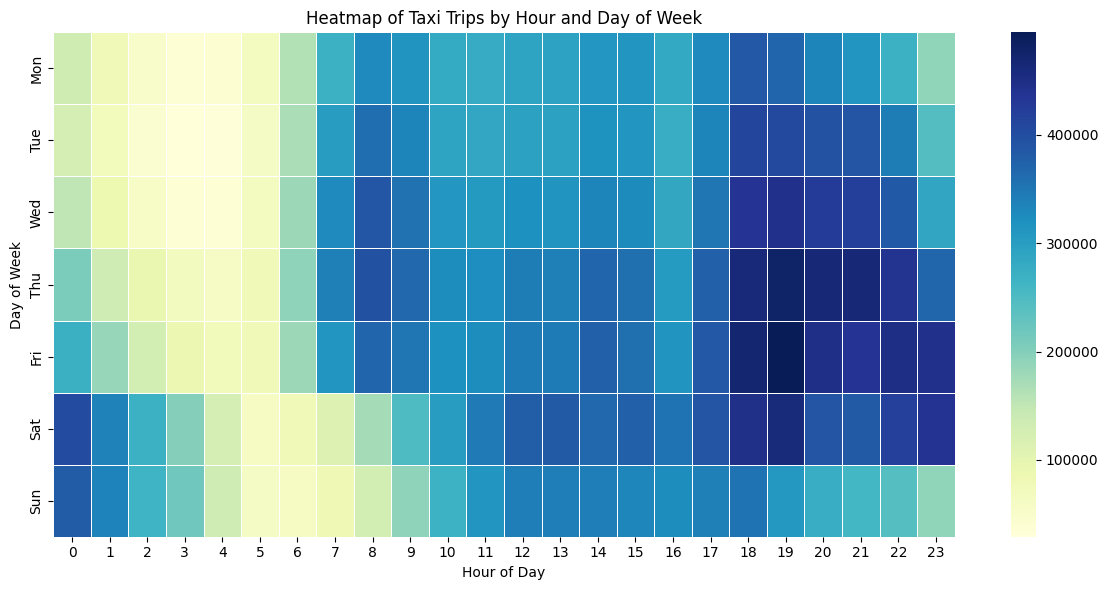

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = df.groupby(['weekday', 'hour']).size().unstack()

day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
heatmap_data.index = [day_labels[i] for i in heatmap_data.index]

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title("Heatmap of Taxi Trips by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

##### Friday evenings from 6pm to Saturday 12am is the busiest period during the week

## Pick-Up Locations

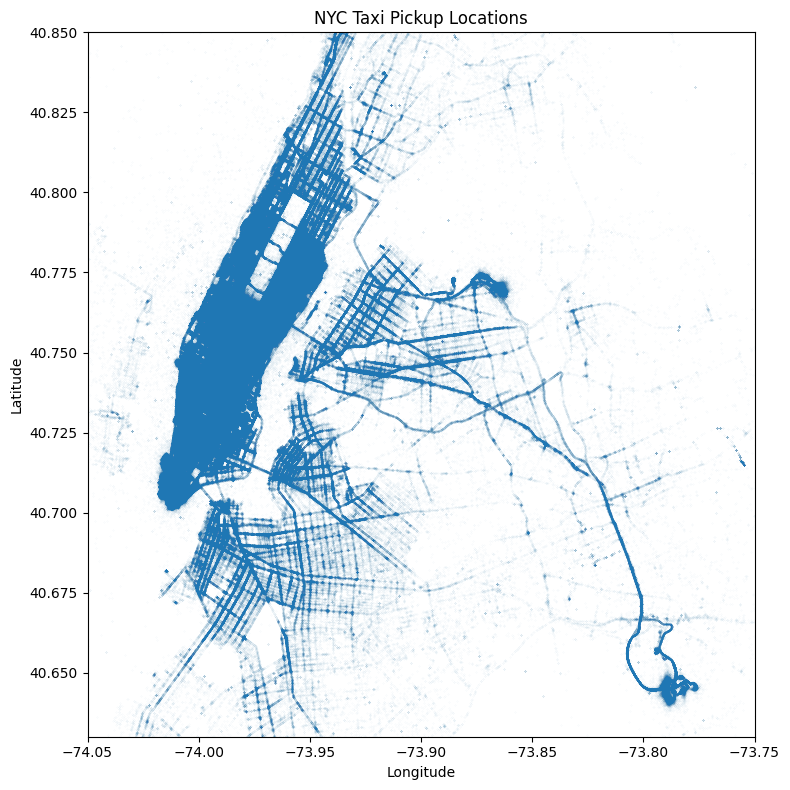

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(df['pickup_lon'], df['pickup_lat'], s=0.02, alpha=0.1)
plt.title("NYC Taxi Pickup Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-74.05, -73.75])
plt.ylim([40.63, 40.85])
plt.tight_layout()
plt.show()

## Drop-off Locations

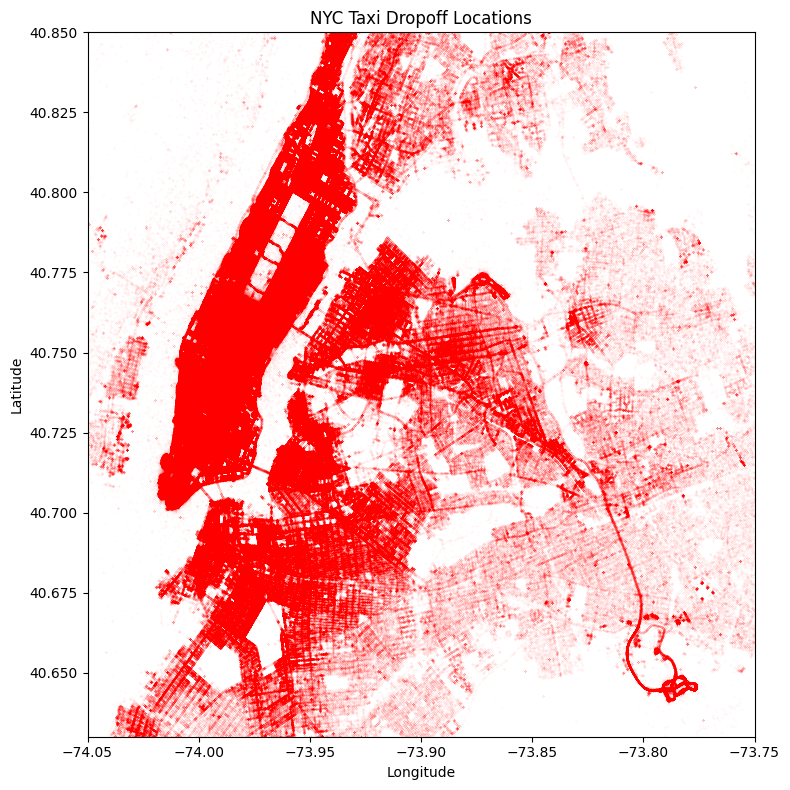

In [11]:
plt.figure(figsize=(8, 8))
plt.scatter(df['dropoff_lon'], df['dropoff_lat'], s=0.02, alpha=0.1, color='red')
plt.title("NYC Taxi Dropoff Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-74.05, -73.75])
plt.ylim([40.63, 40.85])
plt.tight_layout()
plt.show()

##### More drop-off locations in parts of Queens and Brooklyn

## Plotting Sample Pick-Up Locations on a real open-street map

In [13]:
import folium
from folium.plugins import HeatMap

pickup_sample = df[['pickup_lat', 'pickup_lon']].dropna().sample(10_000)

m = folium.Map(location=[40.75, -73.97], zoom_start=12, tiles="OpenStreetMap")
HeatMap(data=pickup_sample.values, radius=7).add_to(m)

m

/Users/barraharrison/Desktop/2025 Coding/NYC-Taxi-Trips-Analysis/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Plotting the Sample Drop-Off Locations on a real open-street map

In [14]:
import folium
from folium.plugins import HeatMap

dropoff_sample = df[['dropoff_lat', 'dropoff_lon']].dropna().sample(10_000)

m_dropoff = folium.Map(location=[40.75, -73.97], zoom_start=12, tiles="OpenStreetMap")
HeatMap(data=dropoff_sample.values, radius=7).add_to(m_dropoff)

m_dropoff

##### The Airport in Jersey is busy when it comes to dropping people off from NYC
##### There are more drop-off points when it comes to outside of Manhattan

## Payment Type Breakdown

In [5]:
payment_map = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip"
}

df['payment_label'] = df['payment_type'].map(payment_map)

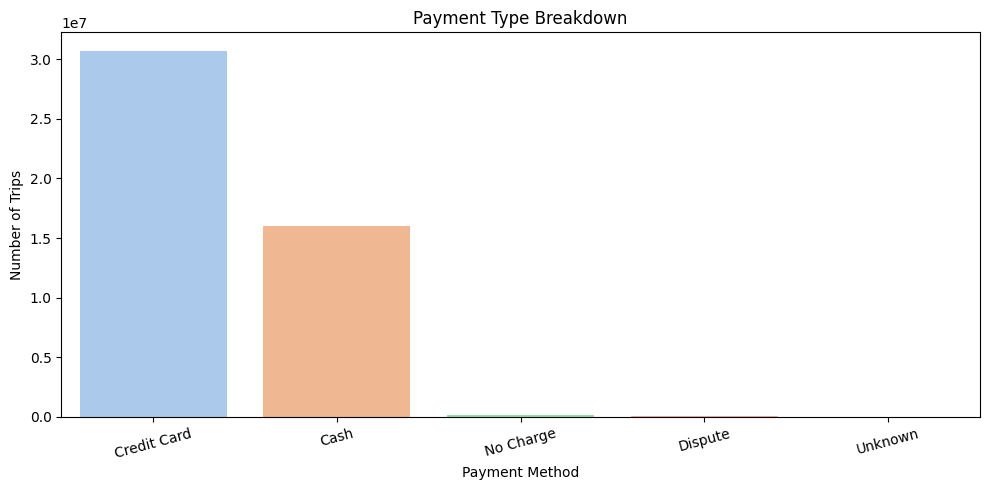

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(
    data=df,
    x='payment_label',
    hue='payment_label',
    order=df['payment_label'].value_counts().index,
    palette='pastel',
    legend=False
)
plt.title("Payment Type Breakdown")
plt.xlabel("Payment Method")
plt.ylabel("Number of Trips")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## Vendor Usage by Payment Method

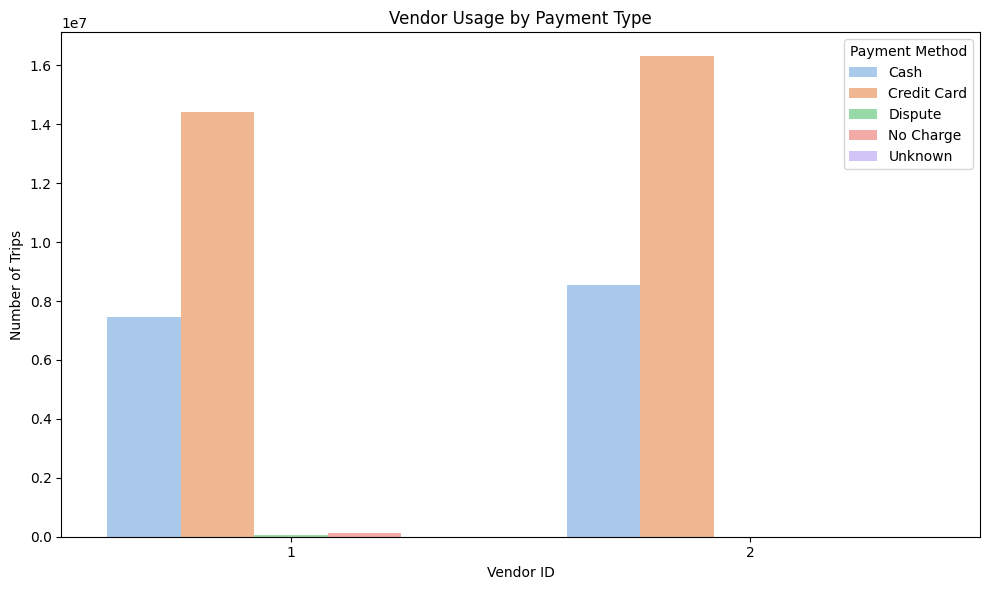

In [9]:
vendor_payment_counts = df.groupby(['VendorID', 'payment_label']).size().reset_index(name='count')

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    data=vendor_payment_counts,
    x='VendorID',
    y='count',
    hue='payment_label',
    palette='pastel'
)
plt.title("Vendor Usage by Payment Type")
plt.xlabel("Vendor ID")
plt.ylabel("Number of Trips")
plt.legend(title="Payment Method")
plt.tight_layout()
plt.show()

### Vendor 1: Creative Mobile Technologies (CMT)
### Vendor 2: Verifone

#### Card payments trump cash payments in the case of both vendors